C:\Users\SAFIN\AppData\Local\Temp\ipykernel_33064\3466514629.py:12: DtypeWarning: Columns (11,13,86,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate  \
0  2024        4     12           4          3  2024-12-04   
1  2024        4     12           1          7  2024-12-01   
2  2024        4     12           2          1  2024-12-02   
3  2024        4     12           3          2  2024-12-03   
4  2024        4     12           4          3  2024-12-04   

  Marketing_Airline_Network Operated_or_Branded_Code_Share_Partners  \
0                        AA                            AA_CODESHARE   
1                        AA                            AA_CODESHARE   
2                        AA                            AA_CODESHARE   
3                        AA                            AA_CODESHARE   
4                        AA                            AA_CODESHARE   

   DOT_ID_Marketing_Airline IATA_Code_Marketing_Airline  ...  Div4TailNum  \
0                     19805                          AA  ...          NaN   
1                     19805                   

Dropped columns: ['OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID']
New shape of dataframe: (1910725, 56)
Dropped columns: ['DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline']
New shape of dataframe: (1910725, 54)
Cancelled and diverted flights removed.
Remaining rows: 1877407
Missing values per column:
 Series([], dtype: int64)
Year                                         int64
Quarter                                      int64
Month                                        int64
DayofMonth                                   int64
DayOfWeek                                    int64
FlightDate                                  object
Marketing_Airline_Network                   object
Operated_or_Branded_Code_Share_Partners     object
Flight_Number_Marketing_Airline              int64
Operating_Airline                           object
DOT_ID_Operating_Airline                     int64
IATA_Code_Operating_Airline    

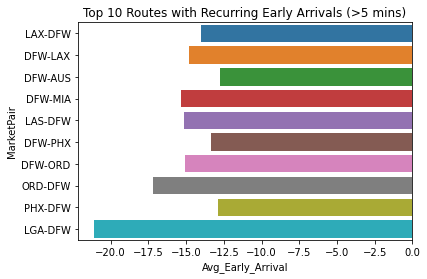

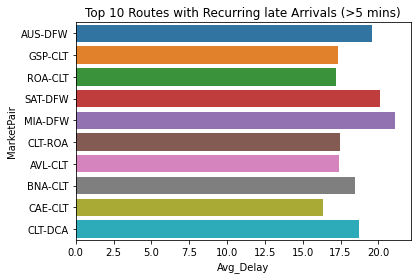

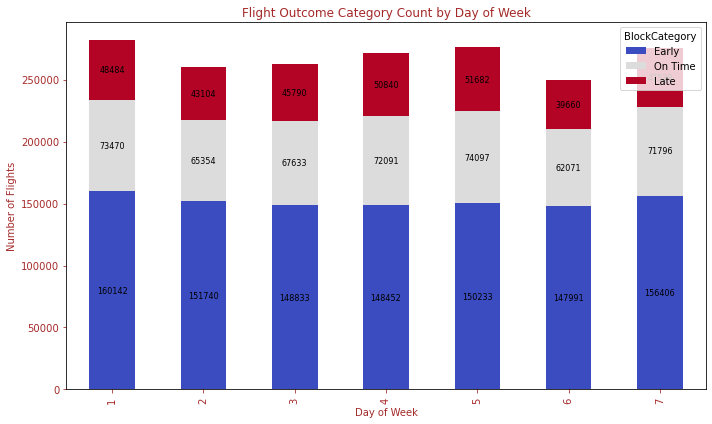

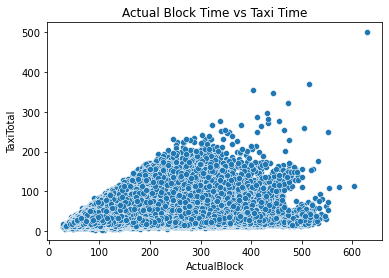

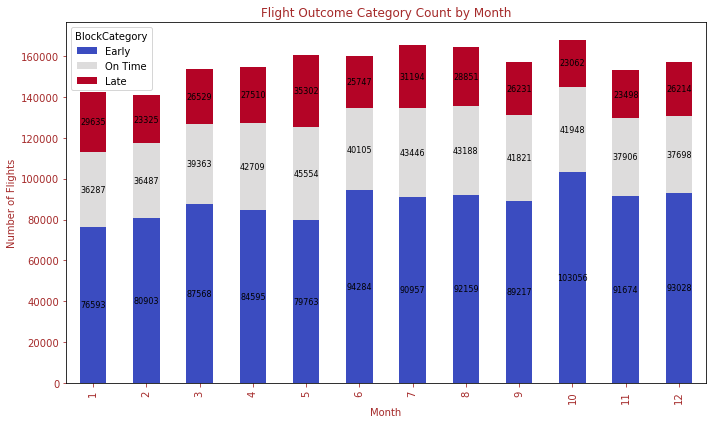

Shape of the dataset: (1877407, 26)
Year                          int64
Quarter                       int64
Month                         int64
DayofMonth                    int64
DayOfWeek                     int64
DOT_ID_Operating_Airline      int64
CRSDepTime                    int64
DepTime                     float64
DepDelay                    float64
DepDelayMinutes             float64
DepDel15                    float64
DepartureDelayGroups        float64
WheelsOff                   float64
WheelsOn                    float64
CRSArrTime                    int64
ArrTime                     float64
ArrDelay                    float64
ArrDelayMinutes             float64
ArrDel15                    float64
ArrivalDelayGroups          float64
Cancelled                     int64
Diverted                      int64
ActualBlock                 float64
Flights                       int64
Distance                      int64
DivAirportLandings            int64
dtype: object

Unique value 

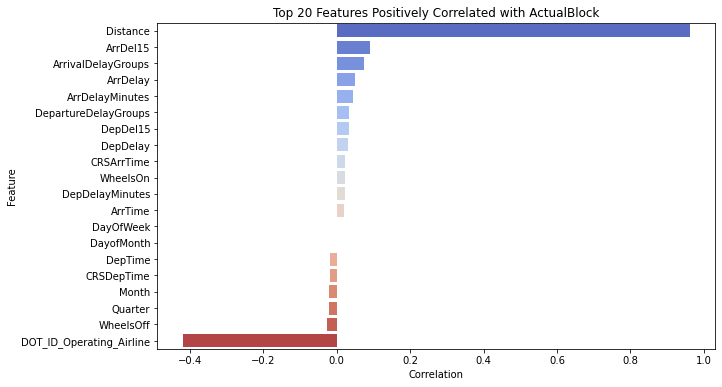

RMSE: 18.03 minutes
 R² Score: 0.9226
Training RMSE: 17.99 minutes
Training R² Score: 0.9231
Adjusted R² Score: 0.9226


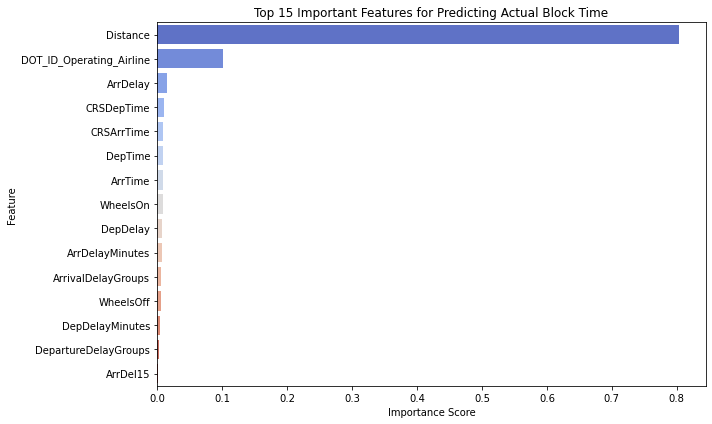

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


file_path = r"C:\Users\SAFIN\Desktop\block\Updated_Master.csv"
df = pd.read_csv(file_path)

print(df.head())

# Drop columns with more than 50% missing values
threshold = len(df) * 0.5
df_cleaned = df.dropna(thresh=threshold, axis=1)
print("Preview of cleaned data:")
print(df_cleaned.head())

#output_path = r"C:\Users\SAFIN\Desktop\block\Updated_Master_Cleaned.csv"
#df_cleaned.to_csv(output_path, index=False)

#print(f"\n Cleaned file saved to: {output_path}")


file_path = r"C:\Users\SAFIN\Desktop\block\Updated_Master_Cleaned.csv"
df = pd.read_csv(file_path)
print("Shape of the dataset:", df.shape)
print("\nColumn info:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nSummary statistics:")
print(df.describe())
print("\nFirst 5 rows:")
print(df.head())

columns_to_drop = [col for col in df.columns if col.strip().upper().endswith("ID")]
df = df.drop(columns=columns_to_drop)

print("Dropped columns:", columns_to_drop)
print("New shape of dataframe:", df.shape)

columns_to_drop = ['DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline']

# Drop them only if they exist in the DataFrame
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

print("Dropped columns:", columns_to_drop)
print("New shape of dataframe:", df.shape)

df = df.rename(columns={
    "ActualElapsedTime": "ActualBlock",
    "CRSElapsedTime": "ScheduleBlock"
})

df = df[(df["Cancelled"] != 1) & (df["Diverted"] != 1)]

print("Cancelled and diverted flights removed.")
print("Remaining rows:", df.shape[0])

missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Missing values per column:\n", missing)

print(df.dtypes)
print("\nUnique value count per column:\n", df.nunique().sort_values())

# Create Market Pair column
df["MarketPair"] = df["Origin"] + "-" + df["Dest"]

# Create difference column
df["BlockDiff"] = df["ActualBlock"] - df["ScheduleBlock"]


early_flights = df[df["BlockDiff"] < -5]

# Group by market pair and count
early_summary = early_flights.groupby("MarketPair").agg(
    Count=("BlockDiff", "count"),
    Avg_Early_Arrival=("BlockDiff", "mean")
).sort_values(by="Count", ascending=False)

# Show top 10 recurring early arrival routes
print(early_summary.head(10))


late_flights = df[df["BlockDiff"] > 5]
late_summary = late_flights.groupby("MarketPair").agg(
    Count=("BlockDiff", "count"),
    Avg_Delay=("BlockDiff", "mean")
).sort_values(by="Count", ascending=False)
print(late_summary.head(10))


top_early = early_summary.head(10).reset_index()
sns.barplot(x="Avg_Early_Arrival", y="MarketPair", data=top_early)
plt.title("Top 10 Routes with Recurring Early Arrivals (>5 mins)")
plt.show()

top_late = late_summary.head(10).reset_index()
sns.barplot(x="Avg_Delay", y="MarketPair", data=top_late)
plt.title("Top 10 Routes with Recurring late Arrivals (>5 mins)")
plt.show()

# Create block time categories
df["BlockCategory"] = pd.cut(df["BlockDiff"],
    bins=[-float("inf"), -5, 5, float("inf")],
    labels=["Early", "On Time", "Late"]
)

# Group and count
count_by_day = df.groupby(["DayOfWeek", "BlockCategory"]).size().unstack()

ax = count_by_day.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="coolwarm")

# Set title and axis labels with brown color
plt.title("Flight Outcome Category Count by Day of Week", color='brown')
plt.ylabel("Number of Flights", color='brown')
plt.xlabel("Day of Week", color='brown')

# Change x and y tick labels to brown
ax.tick_params(axis='x', colors='brown')
ax.tick_params(axis='y', colors='brown')

# Add data labels inside each segment
for idx, day in enumerate(count_by_day.index):
    cumulative = 0
    for cat in count_by_day.columns:
        value = count_by_day.loc[day, cat]
        if value > 0:
            ax.text(idx, cumulative + value / 2 - 5, str(int(value)), 
                    ha="center", va="center", fontsize=8)
            cumulative += value

plt.tight_layout()
plt.show()

df["TaxiTotal"] = df["TaxiOut"] + df["TaxiIn"]
sns.scatterplot(data=df, x="ActualBlock", y="TaxiTotal")
plt.title("Actual Block Time vs Taxi Time")
plt.show()


count_by_Month = df.groupby(["Month", "BlockCategory"]).size().unstack()

# Plot stacked bar chart
ax = count_by_Month.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="coolwarm")

# Set title and axis labels with brown color
plt.title("Flight Outcome Category Count by Month", color='brown')
plt.ylabel("Number of Flights", color='brown')
plt.xlabel("Month", color='brown')

# Change x and y tick labels to brown
ax.tick_params(axis='x', colors='brown')
ax.tick_params(axis='y', colors='brown')

# Add data labels inside each segment
for idx, month in enumerate(count_by_Month.index):
    cumulative = 0
    for cat in count_by_Month.columns:
        value = count_by_Month.loc[month, cat]
        if value > 0:
            ax.text(idx, cumulative + value / 2 - 5, str(int(value)), 
                    ha="center", va="center", fontsize=8)
            cumulative += value            

plt.tight_layout()
plt.show()

#Dropping variables to reduce multicolinearity and varaible that are highly coorelated to acutal block

df.columns = df.columns.str.strip()
cols_to_drop = [
    # Origin/Dest redundancies
    "OriginCityName", "OriginState", "OriginStateFips", "OriginStateName", "OriginWac",
    "DestCityName", "DestState", "DestStateFips", "DestStateName", "DestWac", "BlockCategory", 
    "Operating_Airline","DepTimeBlk", "ArrTimeBlk", "Marketing_Airline_Network", "TaxiIn", "TaxiOut", "AirTime", "TaxiTotal", 
    "BlockDiff", "Origin", "Dest",
    
    # Airline duplicates
    "IATA_Code_Operating_Airline", "DistanceGroup", "Operated_or_Branded_Code_Share_Partners", "FlightDate", "IATA_Code_Marketing_Airline",
    
    # Less useful or ID-like
    "Tail_Number", "Flight_Number_Marketing_Airline", "Flight_Number_Operating_Airline",
    "MarketPair", "Duplicate", "ScheduleBlock"
]

df = df.drop(columns=cols_to_drop, errors="ignore")
print("Shape of the dataset:", df.shape)
print(df.dtypes)
print("\nUnique value count per column:\n", df.nunique().sort_values())


# Select numeric columns only
df_numeric = df.select_dtypes(include=['int64', 'float64'])

# Calculate correlation matrix 
corr = df_numeric.corr()

# Get correlation with ActualBlock
target_corr = corr["ActualBlock"].drop("ActualBlock").sort_values(ascending=False)

# Plot top 20 positively correlated features
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.values[:20], y=target_corr.index[:20], palette="coolwarm")
plt.title("Top 20 Features Positively Correlated with ActualBlock")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()


# STEP 2: Define features and target
X = df.drop(columns=["ActualBlock"])
y = df["ActualBlock"]

# STEP 4: Reduce dataset size (optional - use only if needed)
# X, _, y, _ = train_test_split(X, y, train_size=0.3, random_state=42)

# STEP 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# STEP 6: Train Random Forest with lower resource usage
model = RandomForestRegressor(
    n_estimators=25,         # Reduce number of trees (try 25 or 10 if still fails)
    max_depth=10,            # Limit depth of each tree
    max_features="sqrt",     # Use sqrt of total features per split
    random_state=42,
    n_jobs=1                 # Avoid parallelism if memory is limited
)
model.fit(X_train, y_train)



# Evaluation
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f} minutes")
print(f" R² Score: {r2:.4f}")

# Predict on training set
y_train_pred = model.predict(X_train)

# Training performance
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Training RMSE: {train_rmse:.2f} minutes")
print(f"Training R² Score: {train_r2:.4f}")

n = X_test.shape[0]  # number of rows in test set
k = X_test.shape[1]  # number of features

adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print(f"Adjusted R² Score: {adj_r2:.4f}")

# Get feature importances
importances = model.feature_importances_

# Get feature names
feature_names = X.columns

# Create DataFrame for easy sorting and plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(15), palette="coolwarm")
plt.title("Top 15 Important Features for Predicting Actual Block Time")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error

# STEP 1: Drop missing targets
df = df.dropna(subset=["ActualBlock"])

# STEP 2: Subsample data to speed up training
df_sample = df.sample(n=100_000, random_state=42)  # adjust size based on Colab RAM

# STEP 3: Encode categoricals (frequency encoding)
#for col in df_sample.select_dtypes(include="object").columns:
#    freq = df_sample[col].value_counts(normalize=True)
#    df_sample[col] = df_sample[col].map(freq)

# STEP 4: Define features & target
X = df_sample.drop(columns=["ActualBlock"])
y = df_sample["ActualBlock"]

# STEP 5: Simplified model
model = RandomForestRegressor(n_estimators=50, max_depth=15, random_state=42, n_jobs=1)

# STEP 6: K-Fold CV (3 folds for speed)
cv = KFold(n_splits=3, shuffle=True, random_state=42)
scoring = 'neg_root_mean_squared_error'
scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=1)

# STEP 7: Cross-validation
scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=1)

# STEP 8: Report
print("RMSE per fold:", -scores)
print(f"Mean RMSE: {-scores.mean():.2f} minutes")
print(f"Std Dev: {scores.std():.2f} minutes")

RMSE per fold: [10.31965745 10.37691554 10.36485145]
Mean RMSE: 10.35 minutes
Std Dev: 0.02 minutes
